# 탄소배출권 가격 예측 프로그램

- 사용 데이터 : 종가, 시가, 고가, 저가, 거래량, 거래대금, 변환 날짜, 대비
- 2015년부터 2020년 6월까지의 데이터를 사용하여 모델 생성
- 생성한 모델로 2020년 7월부터 8월까지의 데이터를 테스트, 정확도 비교

## 1. 데이터 임포트

In [40]:
def del_comma(df):
    df['end_pr'] = df['end_pr'].apply(lambda x:str(x).replace(',', ''))
    df['diff'] = df['diff'].apply(lambda x:str(x).replace(',', ''))
    df['start_pr'] = df['start_pr'].apply(lambda x:str(x).replace(',', ''))
    df['high_pr'] = df['high_pr'].apply(lambda x:str(x).replace(',', ''))
    df['low_pr'] = df['low_pr'].apply(lambda x:str(x).replace(',', ''))
    df['volume'] = df['volume'].apply(lambda x:str(x).replace(',', ''))
    df['sum_pr'] = df['sum_pr'].apply(lambda x:str(x).replace(',', ''))
    return df


import pandas as pd
kau19 = pd.read_excel('KAU19.xls'
                      , names=['date', 'end_pr', 'diff', 'diff_per','start_pr', 'high_pr', 'low_pr', 'volume', 'sum_pr', '_', '__', '___']
                      , convert_float=False)
kau19 = kau19.loc[:, 'date':'sum_pr']
kau19 = del_comma(kau19)
#print(kau19.info())
#print(kau19.head())

kau20 = pd.read_excel('KAU20.xls',
                      names=['date', 'end_pr', 'diff', 'diff_per','start_pr', 'high_pr', 'low_pr', 'volume', 'sum_pr', '_', '__', '___']
                     , convert_float=False)
kau20 = kau20.loc[:, 'date':'sum_pr']
kau20 = del_comma(kau20)
#print(kau20.head())
#print(kau20.tail())

## 2. 데이터 분리, 전처리
- 학습할 데이터와 테스트 데이터 분리
- 2020년 6월 이전까지의 데이터를 사용해서 학습
- 2020년 6월 이후 데이터를 사용해서 테스트
- 거래가 일어나지 않은 날은 제외
- 날짜 데이터를 시작 일에 대한 weight를 생성
    -> 특정 시점 이후 거래가 활발해지는 배출권 거래 시장을 반영하기 위함
- 정규화
 

In [41]:
def check_sign(diff, diff_per):
    diff = str(diff)
    if(diff_per<0):
        if(diff[0]!='-'):
            return '-'+diff
        #print(row)
        #print('::::::::::::::::::::::')
    return diff

kau19['diff']=kau19.apply(lambda x:check_sign(x['diff'], x['diff_per']), axis=1)
kau20['diff']=kau20.apply(lambda x:check_sign(x['diff'], x['diff_per']), axis=1)

#print(kau19.head())
#print(kau20.head())

In [42]:
def check_start_high_low(pr, end_pr):
    if(pr=='-'):
        #print(row['start_pr'], row['end_pr'])
        return end_pr
    return pr

kau19['start_pr']=kau19.apply(lambda x:check_start_high_low(x['start_pr'], x['end_pr']), axis=1)
kau19['high_pr']=kau19.apply(lambda x:check_start_high_low(x['high_pr'], x['end_pr']), axis=1)
kau19['low_pr']=kau19.apply(lambda x:check_start_high_low(x['low_pr'], x['end_pr']), axis=1)
kau20['start_pr']=kau20.apply(lambda x:check_start_high_low(x['start_pr'], x['end_pr']), axis=1)
kau20['high_pr']=kau20.apply(lambda x:check_start_high_low(x['high_pr'], x['end_pr']), axis=1)
kau20['low_pr']=kau20.apply(lambda x:check_start_high_low(x['low_pr'], x['end_pr']), axis=1)

#print(kau19.head())
#print(kau20.head())

In [45]:
import numpy as np
def set_weight(df):
    #df.sort_values(by=['date'], inplace=True)
    df['wei'] = np.arange(1, len(df.index)+1,1,dtype=object)
    return df
kau19 = set_weight(kau19)
kau20 = set_weight(kau20)
print(kau19.head(10))
print(kau20.head(10))

         date   end_pr    diff  diff_per  start_pr  high_pr   low_pr   volume  \
0  2020/08/21  19850.0   150.0      0.76   19700.0  19850.0  19700.0  10500.0   
1  2020/08/20  19700.0   700.0      3.68   19500.0  19700.0  19300.0   9000.0   
2  2020/08/19  19000.0  1200.0      6.74   17900.0  19000.0  17900.0  18200.0   
3  2020/08/18  17800.0    50.0      0.28   17750.0  17800.0  17750.0  10000.0   
4  2020/08/14  17750.0    50.0      0.28   17500.0  17750.0  17500.0   7400.0   
5  2020/08/13  17700.0   500.0      2.91   17800.0  17800.0  17700.0   4500.0   
6  2020/08/12  17200.0   100.0      0.58   17100.0  17200.0  17100.0   4500.0   
7  2020/08/11  17100.0     0.0      0.00   17100.0  17100.0  17100.0   4500.0   
8  2020/08/10  17100.0    50.0      0.29   17050.0  17100.0  17050.0   4700.0   
9  2020/08/07  17050.0  1550.0     10.00   16300.0  17050.0  16300.0  62735.0   

         sum_pr wei  
0  2.078250e+08   1  
1  1.745000e+08   2  
2  3.378750e+08   3  
3  1.776250e+08   4 

In [47]:
def set_float(df):
    df['end_pr'] = df['end_pr'].astype(float)
    df['diff'] = df['diff'].astype(float)
    df['start_pr'] = df['start_pr'].astype(float)
    df['high_pr'] = df['high_pr'].astype(float)
    df['low_pr'] = df['low_pr'].astype(float)
    df['volume'] = df['volume'].astype(float)
    df['sum_pr'] = df['sum_pr'].astype(float)
    df['wei'] = df['wei'].astype(float)
    return df
kau19_float = set_float(kau19)
kau20_float = set_float(kau20)
#print(kau19_float.info())
print(kau19_float.head(10))
print(kau20_float.tail(10))

         date   end_pr    diff  diff_per  start_pr  high_pr   low_pr   volume  \
0  2020/08/21  19850.0   150.0      0.76   19700.0  19850.0  19700.0  10500.0   
1  2020/08/20  19700.0   700.0      3.68   19500.0  19700.0  19300.0   9000.0   
2  2020/08/19  19000.0  1200.0      6.74   17900.0  19000.0  17900.0  18200.0   
3  2020/08/18  17800.0    50.0      0.28   17750.0  17800.0  17750.0  10000.0   
4  2020/08/14  17750.0    50.0      0.28   17500.0  17750.0  17500.0   7400.0   
5  2020/08/13  17700.0   500.0      2.91   17800.0  17800.0  17700.0   4500.0   
6  2020/08/12  17200.0   100.0      0.58   17100.0  17200.0  17100.0   4500.0   
7  2020/08/11  17100.0     0.0      0.00   17100.0  17100.0  17100.0   4500.0   
8  2020/08/10  17100.0    50.0      0.29   17050.0  17100.0  17050.0   4700.0   
9  2020/08/07  17050.0  1550.0     10.00   16300.0  17050.0  16300.0  62735.0   

         sum_pr   wei  
0  2.078250e+08   1.0  
1  1.745000e+08   2.0  
2  3.378750e+08   3.0  
3  1.776250e

In [48]:
from sklearn.preprocessing import MinMaxScaler

def scale(df):
    scaler = MinMaxScaler()
    scale_cols = ['end_pr', 'diff', 'diff_per', 'start_pr', 'high_pr', 'low_pr', 'volume', 'sum_pr', 'wei']
    df_scaled = scaler.fit_transform(df[scale_cols])
    df_scaled = pd.DataFrame(df_scaled)
    df_scaled.columns = scale_cols
    df_scaled['date'] = df['date']
    return df_scaled

scaled_kau19 = scale(kau19_float)
scaled_kau20 = scale(kau20_float)
#scaled_kau19['date'] = kau19_float['date']
#scaled_kau20['date'] = kau20_float['date']
print(scaled_kau19.head(10))
print(scaled_kau20.tail(10))

     end_pr      diff  diff_per  start_pr   high_pr    low_pr    volume  \
0  0.187259  0.629921    0.5380  0.205607  0.186898  0.205993  0.023769   
1  0.181467  0.716535    0.6840  0.198131  0.181118  0.191011  0.020373   
2  0.154440  0.795276    0.8370  0.138318  0.154143  0.138577  0.041199   
3  0.108108  0.614173    0.5140  0.132710  0.107900  0.132959  0.022637   
4  0.106178  0.614173    0.5140  0.123364  0.105973  0.123596  0.016751   
5  0.104247  0.685039    0.6455  0.134579  0.107900  0.131086  0.010187   
6  0.084942  0.622047    0.5290  0.108411  0.084778  0.108614  0.010187   
7  0.081081  0.606299    0.5000  0.108411  0.080925  0.108614  0.010187   
8  0.081081  0.614173    0.5145  0.106542  0.080925  0.106742  0.010639   
9  0.079151  0.850394    1.0000  0.078505  0.078998  0.078652  0.142013   

     sum_pr       wei        date  
0  0.013318  0.000000  2020/08/21  
1  0.011183  0.002268  2020/08/20  
2  0.021652  0.004535  2020/08/19  
3  0.011383  0.006803  2020/08

In [49]:
BASE = '2020/06/15'

drop_kau19 = scaled_kau19[:][kau19.volume != '0']
drop_kau20 = scaled_kau20[:][kau20.volume != '0']
X_19 = drop_kau19[['date', 'diff', 'diff_per', 'start_pr', 'high_pr', 'low_pr', 'volume', 'sum_pr', 'wei']]
X_20 = drop_kau20[['date', 'diff', 'diff_per', 'start_pr', 'high_pr', 'low_pr', 'volume', 'sum_pr', 'wei']]
X_20_train = X_20[:][X_20.date < BASE]
X_20_test = X_20[:][X_20.date >= BASE]

X_train = pd.concat([X_19, X_20_train], ignore_index=True, axis=0)
X_train = X_train.loc[:,'diff' : 'wei']
X_test = X_20_test.loc[:, 'diff' : 'wei']
#print(X_train.head(50))
#print(X_train.info())

Y_19 = drop_kau19[['date', 'end_pr']]
Y_20 = drop_kau20[['date', 'end_pr']]
Y_20_train = Y_20[:][Y_20.date < BASE]
Y_20_test = Y_20[:][Y_20.date >= BASE]

Y_train = pd.concat([Y_19, Y_20_train], ignore_index=True, axis=0)
Y_train = Y_train.loc[:, 'end_pr']
Y_test = Y_20_test.loc[:, 'end_pr']
#print(Y_train.head())

C:\Users\johnh\anaconda3\envs\machinelearning\lib\site-packages\pandas\core\ops\array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


In [50]:
def set_data(x, y, window_size=20):
    feature = []
    label = []
    for i in range(len(x)-window_size):
        feature.append(np.array(x.iloc[i:i+window_size]))
        label.append(np.array(y.iloc[i+window_size]))
    return np.array(feature), np.array(label)

X_train_3, Y_train_3 = set_data(X_train, Y_train)
X_test_3, Y_test_3 = set_data(X_test, Y_test)

print(X_train_3.shape, Y_train_3.shape)
print(X_test_3.shape, Y_test_3.shape)

(815, 20, 8) (815,)
(29, 20, 8) (29,)


## 3. 모델 생성, 시각화
### LSTM 알고리즘 사용

In [51]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint

np.random.seed(0)
model_lstm = Sequential()
model_lstm.add(LSTM(
    16,
    input_shape=(X_train_3.shape[1],X_train_3.shape[2]),
    activation='relu',
    return_sequences=False))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mse', optimizer='adam')
print(model_lstm.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 16)                1600      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total params: 1,617
Trainable params: 1,617
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/500
815/815 [==============================] - 0s 389us/step - loss: 9.6959e-05
Epoch 2/500
815/815 [==============================] - 0s 376us/step - loss: 1.1090e-04
Epoch 3/500
815/815 [==============================] - 0s 383us/step - loss: 9.8387e-05
Epoch 4/500
815/815 [==============================] - 0s 382us/step - loss: 1.0144e-04
Epoch 5/500
815/815 [==============================] - 0s 384us/step - loss: 1.0453e-04
Epoch 6/500
815/815 [==============================] - 0s 385us/step - loss: 9.4014e-05
Epoch 7/500
815/815 [==============================] - 0s 511us/step - loss: 1.0049e-04
Epoch 8/500
815/815 [==============================] - 0s 445us/step - loss: 1.0013e-04
Epoch 9/500
815/815 [==============================] - 0s 385us/step - loss: 1.0653e-04
Epoch 10/500
815/815 [==============================] - 0s 501us/step - loss: 1.0519e-04
Epoch 11/500
815/815 [==============================] - 0s 389us/step - loss: 1.0571e-04
Epoch 12/500
815/815 [========

Epoch 93/500
815/815 [==============================] - 1s 614us/step - loss: 9.8275e-05
Epoch 94/500
815/815 [==============================] - 0s 472us/step - loss: 9.5513e-05
Epoch 95/500
815/815 [==============================] - 0s 473us/step - loss: 9.9294e-05
Epoch 96/500
815/815 [==============================] - 0s 494us/step - loss: 9.4965e-05
Epoch 97/500
815/815 [==============================] - 0s 569us/step - loss: 9.9387e-05
Epoch 98/500
815/815 [==============================] - 0s 567us/step - loss: 9.6497e-05
Epoch 99/500
815/815 [==============================] - 0s 478us/step - loss: 9.3589e-05
Epoch 100/500
815/815 [==============================] - 1s 956us/step - loss: 1.0350e-04
Epoch 101/500
815/815 [==============================] - 1s 835us/step - loss: 9.4358e-05
Epoch 102/500
815/815 [==============================] - 1s 734us/step - loss: 9.7047e-05
Epoch 103/500
815/815 [==============================] - 1s 1ms/step - loss: 9.6017e-05
Epoch 104/500
815/8

815/815 [==============================] - 1s 720us/step - loss: 1.1063e-04
Epoch 184/500
815/815 [==============================] - 1s 632us/step - loss: 9.9497e-05
Epoch 185/500
815/815 [==============================] - 1s 637us/step - loss: 9.4539e-05
Epoch 186/500
815/815 [==============================] - 1s 639us/step - loss: 1.0024e-04
Epoch 187/500
815/815 [==============================] - 1s 692us/step - loss: 9.7124e-05 0s - loss: 2.11
Epoch 188/500
815/815 [==============================] - 1s 636us/step - loss: 9.6586e-05
Epoch 189/500
815/815 [==============================] - 1s 635us/step - loss: 8.7596e-05
Epoch 190/500
815/815 [==============================] - 1s 659us/step - loss: 9.5681e-05
Epoch 191/500
815/815 [==============================] - 1s 728us/step - loss: 9.8752e-05
Epoch 192/500
815/815 [==============================] - 1s 696us/step - loss: 9.5250e-05
Epoch 193/500
815/815 [==============================] - 1s 736us/step - loss: 9.6060e-05
Epoch 19

815/815 [==============================] - 1s 701us/step - loss: 9.3389e-05
Epoch 274/500
815/815 [==============================] - 1s 616us/step - loss: 9.2243e-05
Epoch 275/500
815/815 [==============================] - 1s 618us/step - loss: 1.0020e-04
Epoch 276/500
815/815 [==============================] - 1s 664us/step - loss: 8.5296e-05
Epoch 277/500
815/815 [==============================] - 1s 678us/step - loss: 1.0349e-04
Epoch 278/500
815/815 [==============================] - 1s 652us/step - loss: 1.0050e-04
Epoch 279/500
815/815 [==============================] - 1s 674us/step - loss: 1.0046e-04
Epoch 280/500
815/815 [==============================] - 1s 661us/step - loss: 8.9810e-05
Epoch 281/500
815/815 [==============================] - 0s 612us/step - loss: 9.6490e-05
Epoch 282/500
815/815 [==============================] - 1s 650us/step - loss: 9.6818e-05
Epoch 283/500
815/815 [==============================] - 1s 659us/step - loss: 8.9851e-05
Epoch 284/500
815/815 [=

815/815 [==============================] - 1s 758us/step - loss: 9.2361e-05
Epoch 364/500
815/815 [==============================] - 1s 693us/step - loss: 9.3790e-05
Epoch 365/500
815/815 [==============================] - 1s 694us/step - loss: 9.3534e-05
Epoch 366/500
815/815 [==============================] - 1s 778us/step - loss: 9.6395e-05
Epoch 367/500
815/815 [==============================] - 1s 831us/step - loss: 9.2159e-05
Epoch 368/500
815/815 [==============================] - 1s 855us/step - loss: 8.8442e-05
Epoch 369/500
815/815 [==============================] - 1s 752us/step - loss: 9.3288e-05
Epoch 370/500
815/815 [==============================] - 1s 734us/step - loss: 9.2527e-05
Epoch 371/500
815/815 [==============================] - 1s 720us/step - loss: 9.8509e-05
Epoch 372/500
815/815 [==============================] - 1s 747us/step - loss: 9.8545e-05
Epoch 373/500
815/815 [==============================] - 1s 719us/step - loss: 1.0010e-04 0s - loss: 2.
Epoch 374/

815/815 [==============================] - 1s 844us/step - loss: 9.0595e-05 0s - loss: 1.0288e-
Epoch 454/500
815/815 [==============================] - 1s 806us/step - loss: 8.8305e-05 0s - loss: 
Epoch 455/500
815/815 [==============================] - 1s 902us/step - loss: 8.9636e-05
Epoch 456/500
815/815 [==============================] - 1s 788us/step - loss: 1.0280e-04
Epoch 457/500
815/815 [==============================] - 1s 788us/step - loss: 8.7985e-05
Epoch 458/500
815/815 [==============================] - 1s 712us/step - loss: 9.0087e-05
Epoch 459/500
815/815 [==============================] - 1s 683us/step - loss: 1.0069e-04
Epoch 460/500
815/815 [==============================] - 1s 669us/step - loss: 9.5774e-05 0s - loss: 1.0
Epoch 461/500
815/815 [==============================] - 1s 647us/step - loss: 9.2883e-05
Epoch 462/500
815/815 [==============================] - 1s 732us/step - loss: 9.1532e-05
Epoch 463/500
815/815 [==============================] - 1s 847us/s

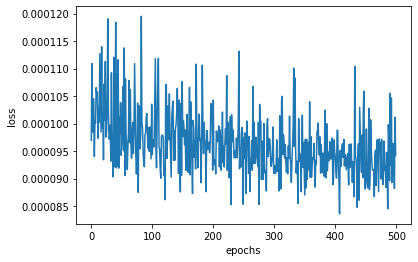

In [57]:
import matplotlib.pyplot as plt
EPOCHS = 500
history_lstm = model_lstm.fit(X_train_3, Y_train_3, epochs=EPOCHS, batch_size=16)
plt.plot(history_lstm.history['loss'])
plt.ylabel('loss')
plt.xlabel('epochs')
plt.show()

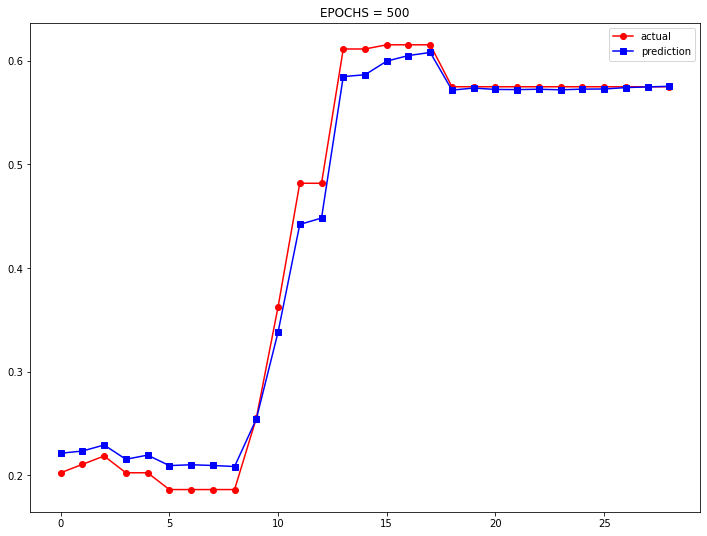

In [59]:
pred = model_lstm.predict(X_test_3)
plt.figure(figsize=(12, 9))
plt.title('EPOCHS = 500')
plt.plot(Y_test_3, 'ro-',label='actual')
plt.plot(pred, 'bs-',label='prediction')
plt.legend()

plt.show()

### GRU 알고리즘 사용

In [60]:
from keras.models import Sequential
from keras.layers import GRU, Dense

model_gru = Sequential()
model_gru.add(GRU(16,
    input_shape=(X_train_3.shape[1],X_train_3.shape[2]),
    activation='relu',
    return_sequences=False))
model_gru.add(Dense(1))
model_gru.compile(loss='mse', optimizer='adam')
model_gru.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, 16)                1200      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 1,217
Trainable params: 1,217
Non-trainable params: 0
_________________________________________________________________


Epoch 1/500
815/815 [==============================] - 0s 507us/step - loss: 1.1012e-04
Epoch 2/500
815/815 [==============================] - 0s 501us/step - loss: 1.0247e-04
Epoch 3/500
815/815 [==============================] - 0s 497us/step - loss: 1.1140e-04
Epoch 4/500
815/815 [==============================] - 0s 503us/step - loss: 1.1092e-04
Epoch 5/500
815/815 [==============================] - 0s 497us/step - loss: 1.3158e-04
Epoch 6/500
815/815 [==============================] - 0s 499us/step - loss: 1.0447e-04
Epoch 7/500
815/815 [==============================] - 0s 500us/step - loss: 1.0099e-04
Epoch 8/500
815/815 [==============================] - 0s 498us/step - loss: 1.2633e-04
Epoch 9/500
815/815 [==============================] - 0s 500us/step - loss: 9.7874e-05
Epoch 10/500
815/815 [==============================] - 1s 650us/step - loss: 1.1510e-04
Epoch 11/500
815/815 [==============================] - 0s 533us/step - loss: 1.0791e-04
Epoch 12/500
815/815 [========

815/815 [==============================] - 0s 490us/step - loss: 9.5140e-05
Epoch 93/500
815/815 [==============================] - 0s 487us/step - loss: 1.0379e-04
Epoch 94/500
815/815 [==============================] - 0s 488us/step - loss: 1.0316e-04
Epoch 95/500
815/815 [==============================] - 0s 485us/step - loss: 1.1203e-04
Epoch 96/500
815/815 [==============================] - 0s 489us/step - loss: 1.0045e-04
Epoch 97/500
815/815 [==============================] - 0s 491us/step - loss: 1.0118e-04
Epoch 98/500
815/815 [==============================] - 0s 505us/step - loss: 1.0636e-04
Epoch 99/500
815/815 [==============================] - 0s 504us/step - loss: 1.0591e-04
Epoch 100/500
815/815 [==============================] - 0s 482us/step - loss: 1.0563e-04
Epoch 101/500
815/815 [==============================] - 0s 491us/step - loss: 1.0240e-04
Epoch 102/500
815/815 [==============================] - 0s 492us/step - loss: 9.7460e-05
Epoch 103/500
815/815 [========

815/815 [==============================] - 0s 473us/step - loss: 9.8558e-05
Epoch 183/500
815/815 [==============================] - 0s 478us/step - loss: 1.0021e-04
Epoch 184/500
815/815 [==============================] - 0s 481us/step - loss: 1.0557e-04
Epoch 185/500
815/815 [==============================] - 0s 481us/step - loss: 1.0033e-04
Epoch 186/500
815/815 [==============================] - 0s 483us/step - loss: 1.0260e-04
Epoch 187/500
815/815 [==============================] - 0s 485us/step - loss: 1.0385e-04
Epoch 188/500
815/815 [==============================] - 0s 529us/step - loss: 1.0311e-04
Epoch 189/500
815/815 [==============================] - 0s 468us/step - loss: 1.0274e-04
Epoch 190/500
815/815 [==============================] - 0s 484us/step - loss: 1.0830e-04
Epoch 191/500
815/815 [==============================] - 0s 486us/step - loss: 1.1040e-04
Epoch 192/500
815/815 [==============================] - 0s 488us/step - loss: 9.1719e-05
Epoch 193/500
815/815 [=

815/815 [==============================] - 0s 489us/step - loss: 1.0665e-04
Epoch 274/500
815/815 [==============================] - 0s 474us/step - loss: 9.7594e-05
Epoch 275/500
815/815 [==============================] - 0s 485us/step - loss: 1.1093e-04
Epoch 276/500
815/815 [==============================] - 0s 491us/step - loss: 1.0799e-04
Epoch 277/500
815/815 [==============================] - 0s 477us/step - loss: 1.0221e-04
Epoch 278/500
815/815 [==============================] - 0s 484us/step - loss: 1.0317e-04
Epoch 279/500
815/815 [==============================] - 0s 485us/step - loss: 1.0216e-04
Epoch 280/500
815/815 [==============================] - 0s 480us/step - loss: 9.9293e-05
Epoch 281/500
815/815 [==============================] - 0s 487us/step - loss: 9.6750e-05
Epoch 282/500
815/815 [==============================] - 0s 487us/step - loss: 9.6721e-05
Epoch 283/500
815/815 [==============================] - 0s 484us/step - loss: 9.9790e-05
Epoch 284/500
815/815 [=

Epoch 364/500
815/815 [==============================] - 0s 508us/step - loss: 9.6896e-05
Epoch 365/500
815/815 [==============================] - 0s 503us/step - loss: 9.4836e-05
Epoch 366/500
815/815 [==============================] - 1s 673us/step - loss: 1.0678e-04
Epoch 367/500
815/815 [==============================] - 1s 916us/step - loss: 1.0251e-04
Epoch 368/500
815/815 [==============================] - 0s 598us/step - loss: 1.0271e-04
Epoch 369/500
815/815 [==============================] - 1s 715us/step - loss: 1.0563e-04
Epoch 370/500
815/815 [==============================] - 0s 588us/step - loss: 9.8453e-05
Epoch 371/500
815/815 [==============================] - 0s 509us/step - loss: 9.4911e-05
Epoch 372/500
815/815 [==============================] - 1s 653us/step - loss: 9.6208e-05
Epoch 373/500
815/815 [==============================] - 1s 633us/step - loss: 9.9108e-05
Epoch 374/500
815/815 [==============================] - 1s 705us/step - loss: 9.9567e-05
Epoch 375/

815/815 [==============================] - 0s 488us/step - loss: 1.1513e-04
Epoch 455/500
815/815 [==============================] - 0s 472us/step - loss: 1.0402e-04
Epoch 456/500
815/815 [==============================] - 0s 605us/step - loss: 9.6847e-05
Epoch 457/500
815/815 [==============================] - 0s 613us/step - loss: 9.2278e-05
Epoch 458/500
815/815 [==============================] - 0s 600us/step - loss: 9.6364e-05
Epoch 459/500
815/815 [==============================] - 1s 615us/step - loss: 1.0409e-04
Epoch 460/500
815/815 [==============================] - 0s 594us/step - loss: 9.3308e-05
Epoch 461/500
815/815 [==============================] - 0s 503us/step - loss: 1.0070e-04
Epoch 462/500
815/815 [==============================] - 0s 536us/step - loss: 1.0112e-04
Epoch 463/500
815/815 [==============================] - 0s 509us/step - loss: 1.0007e-04
Epoch 464/500
815/815 [==============================] - 0s 499us/step - loss: 9.5912e-05
Epoch 465/500
815/815 [=

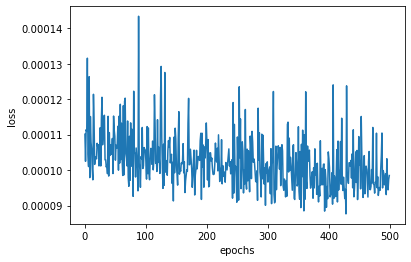

In [66]:
EPOCHS = 500
history = model_gru.fit(X_train_3, Y_train_3, epochs=EPOCHS, batch_size=16)
plt.plot(history.history['loss'])
plt.ylabel('loss')
plt.xlabel('epochs')
plt.show()

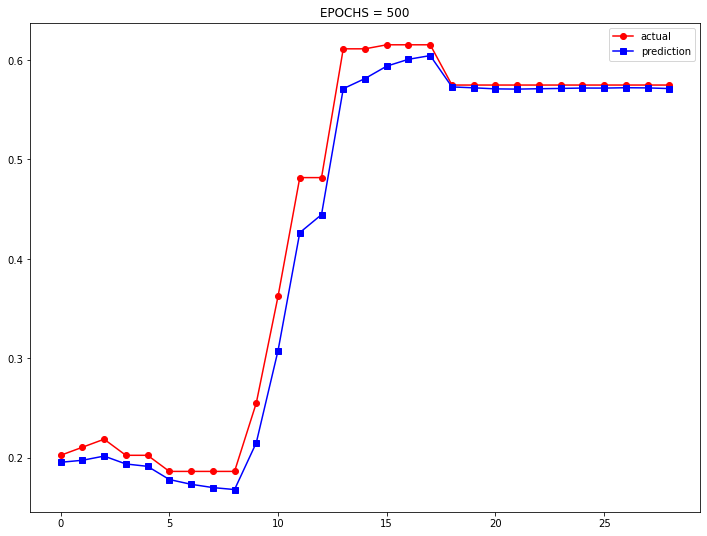

In [67]:
pred = model_gru.predict(X_test_3)
plt.figure(figsize=(12, 9))
plt.title('EPOCHS = 500')
plt.plot(Y_test_3, 'ro-',label='actual')
plt.plot(pred, 'bs-',label='prediction')
plt.legend()
plt.show()